## <i> <span style='color:red'>FORECASTING:AIRLINES DATA</i></span>
### Problem Statement: To predict the airline  passenger's ticket sales 

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the csv data file
data_air = pd.read_excel("Airlines+Data.xlsx")
data_air.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [3]:
# Checking the basic info
data_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [4]:
#cheking the basic statistics of the dataset
data_air.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [5]:
data_air.duplicated().sum()

0

### Basic visualization to identify the past trend and perform analytics on the dataset

<Axes: >

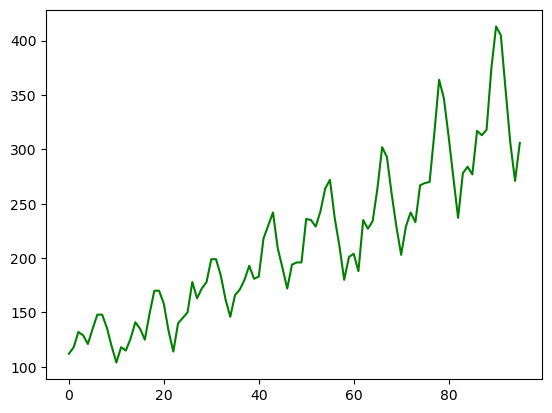

In [6]:
data_air.Passengers.plot(color='green')

<Axes: ylabel='Density'>

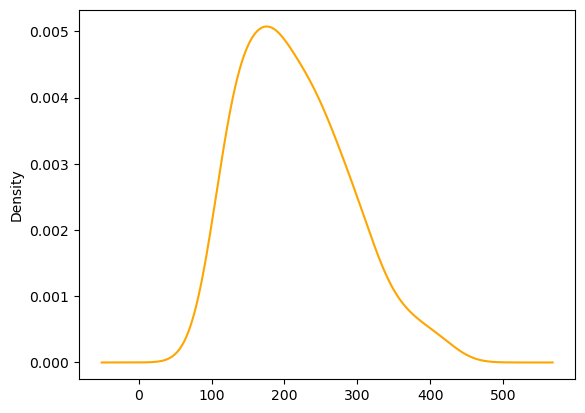

In [7]:
data_air.Passengers.plot(kind='kde',color='orange')

<Axes: ylabel='Frequency'>

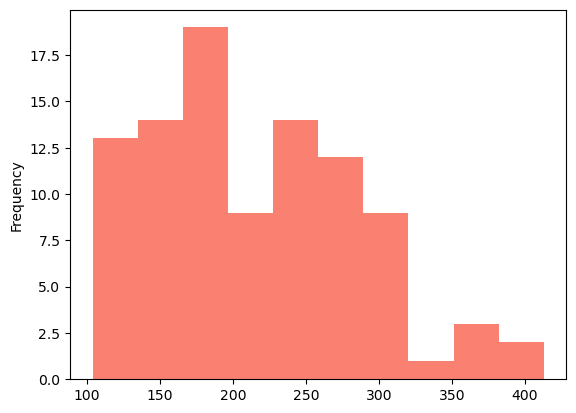

In [8]:
data_air.Passengers.plot(kind='hist',color='salmon')

In [9]:
temp=pd.read_excel('Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True,squeeze=True)

### Box plot- To check the outliers

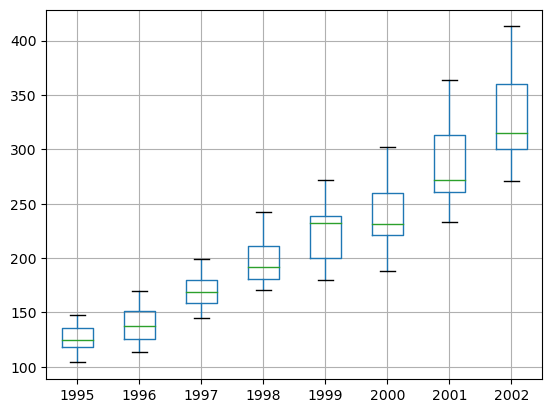

In [10]:
group=temp.groupby(pd.Grouper(freq='A'))
years=pd.DataFrame()
for i,j in group:
    years[i.year]=j.values
years.boxplot()
plt.show()

### Lag plot - plot between lagges values of airline passengers and lagged time

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

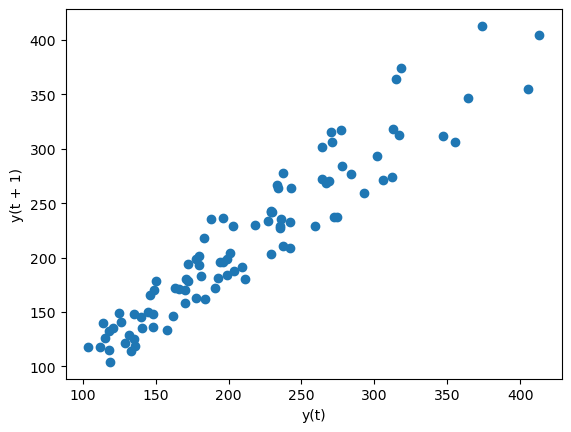

In [11]:
lag_plot(temp)

## Data driven methods

In [12]:
# SPLITTING THE DATASET FOR TRAIN AND TEST
train = data_air.head(77)
test = data_air.tail(19)

### Moving Average and time decomposition plot¶

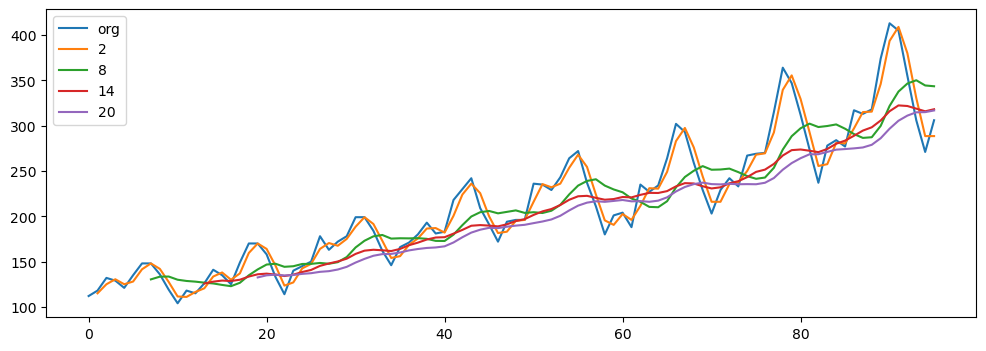

In [13]:
plt.figure(figsize=(12,4))
data_air.Passengers.plot(label="org")
for i in range(2,24,6):
   data_air["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

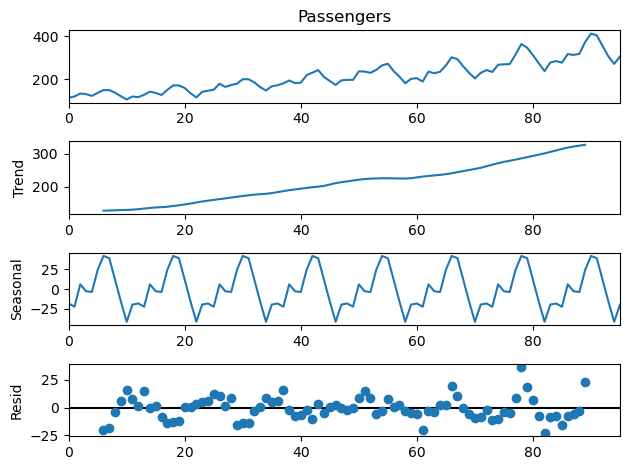

In [14]:
decompose_ts_add = seasonal_decompose(data_air.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

### ACF plots and PACF plots- To identify the significant features that contribute to forecast 

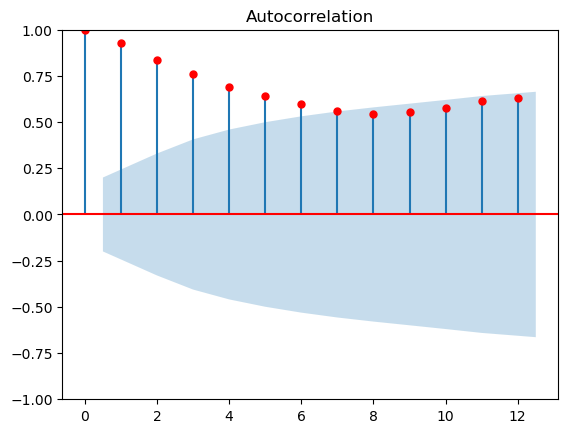

In [15]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data_air.Passengers,lags=12,color='red')
plt.show()


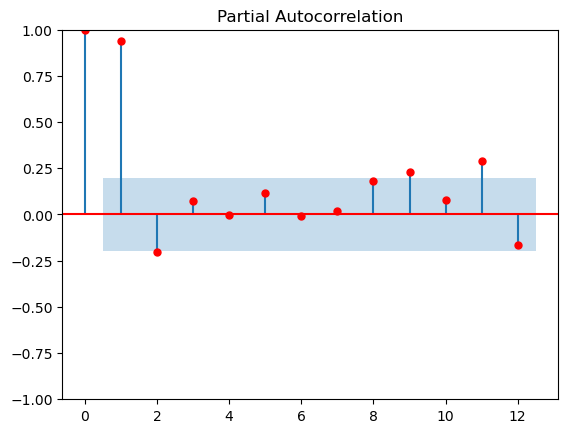

In [16]:
tsa_plots.plot_pacf(data_air.Passengers,lags=12,color='red')
plt.show()

In [17]:
# Creating a user defined function- to calculate the RMSE value
def RMSE(pred,org):
    temp = (np.sqrt(np.mean((np.array(org)-np.array(pred))**2)))
    return temp

### Developing a data driven models 


### 1)Simple exponential method

In [18]:
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
r1=RMSE(pred_ses,test.Passengers) 
r1

80.54332901444145

### 2)Holt's model

In [19]:
# Holt method 
hw_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
r2=RMSE(pred_hw,test.Passengers) 
r2

47.87772864030438

### 3)Holts winter exponential smoothing with additive seasonality and additive trend


In [20]:
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
r3=RMSE(pred_hwe_add_add,test.Passengers) 
r3

35.906424630992824

### 4)Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [21]:
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
r4=RMSE(pred_hwe_mul_add,test.Passengers)
r4

30.906583235206483

### Consolidating the results of all methods into a table

In [22]:
t={"model":pd.Series(['Simple exponential','Holts model','Holts-add seas,add trend','holts-mul sea,add trend']),
   "RMSE":[r1,r2,r3,r4]
  }

In [23]:
t=pd.DataFrame(t)
t

,model,RMSE
0,Simple exponential,80.543329
1,Holts model,47.877729
2,"Holts-add seas,add trend",35.906425
3,"holts-mul sea,add trend",30.906583


In [24]:
# Combining  train and test dataset for final model
final_model = ExponentialSmoothing(data_air["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()

### Forecasting for next 15 time periods

In [25]:
final_model.forecast(15)

96     312.900533
97     308.172851
98     355.534843
99     345.772161
100    345.698761
101    392.473944
102    436.505077
103    429.863114
104    380.176787
105    332.321235
106    290.629755
107    330.595524
108    337.376594
109    332.122977
110    382.987983
dtype: float64

## Inference:
### From the above models, the model with the lowest RMSE value is holts winter exponential smoothing with multiplicative seasonality and additive trend. Thus, we use it to forecast the airlines passengers using the same model